In [ ]:
pip install git+https://github.com/openai/glide-text2im

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-x4vc80pj
  Running command git clone -q https://github.com/openai/glide-text2im /tmp/pip-req-build-x4vc80pj
     |████████████████████████████████| 53 kB 1.9 MB/s 
  Created wheel for glide-text2im: filename=glide_text2im-0.0.0-py3-none-any.whl size=1953661 sha256=cfb00c6d0f1640dd63b12edd4596c12bea186278c3054fad40149c43070a5e6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xkopi4qo/wheels/b4/36/07/46711fd6462da277046c6720504e61546b6e32adc0293abc96
Successfully built glide-text2im


In [ ]:
from PIL import Image
from IPython.display import display
import torch as th
import torch.nn as nn
from glide_text2im.clip.model_creation import create_clip_model
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)
from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer

In [ ]:
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [ ]:
print(device)

cuda


In [ ]:
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' 
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385030726


In [ ]:
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27'
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398361286


In [ ]:
clip_model = create_clip_model(device=device)
clip_model.image_encoder.load_state_dict(load_checkpoint('clip/image-enc', device))
clip_model.text_encoder. load_state_dict(load_checkpoint('clip/text-enc', device))

def show_images(batch: th.Tensor):
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

  0%|          | 0.00/346M [00:00<?, ?iB/s]

  0%|          | 0.00/287M [00:00<?, ?iB/s]

In [ ]:
# prompt

In [132]:
prompt = "Curvaceous, swirling, organic, riotous, turbulent, flowing, amorphous, natural, distorted, uneven, random, lush, organic, bold, intuitive, emotive, chaotic, tumultuous, earthy, churning"
batch_size = 1
guidance_scale=3.0

upsample_temp = 0.997

  0%|          | 0/100 [00:00<?, ?it/s]

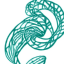

In [137]:
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(tokens, options['text_ctx'])


model_kwargs= dict(tokens=th.tensor([tokens] * batch_size, device=device), mask=th.tensor([mask] * batch_size, dtype=th.bool, device=device))

cond_fn= clip_model.cond_fn([prompt] * batch_size, guidance_scale)

model.del_cache()
samples = diffusion.p_sample_loop(
model,
(batch_size, 3, options["image_size"], options["image_size"]), device=device, clip_denoised=True,
progress=True,
model_kwargs=model_kwargs,
cond_fn=cond_fn)
model.del_cache()

show_images(samples)

  0%|          | 0/27 [00:00<?, ?it/s]

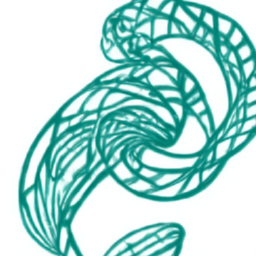

In [138]:
tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)


model_kwargs = dict( 
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

show_images(up_samples)